<a href="https://colab.research.google.com/github/michelmalki/MichelMalki/blob/main/Inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Income: 17964
Total Cost: 12600.0
Profit: 5364.0


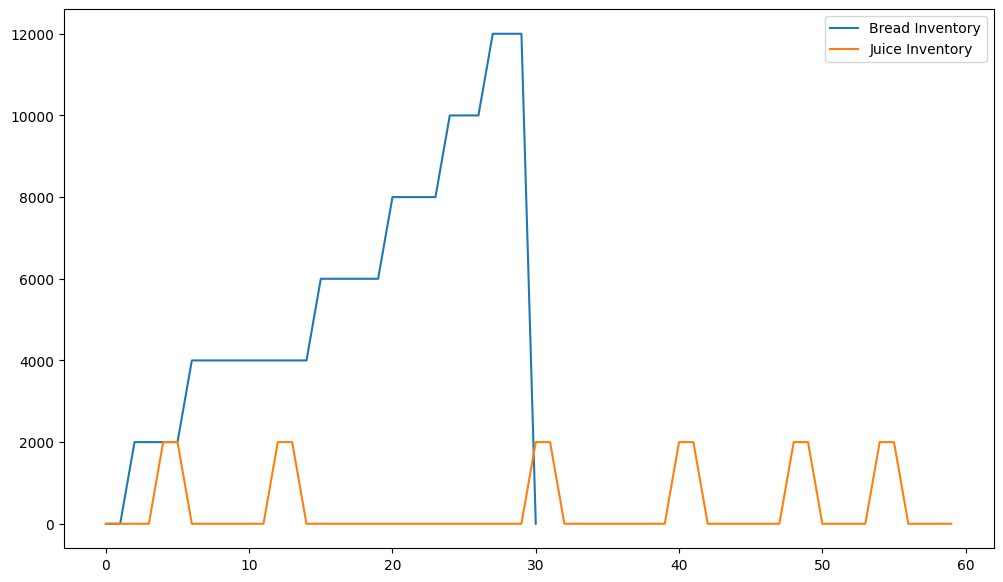

In [26]:
from numpy.random import normal
import matplotlib.pyplot as plt
from random import randint
price_bread = 2
price_juice = 3
# infrastructure
freezerCapacity = 2000
ovenCapacity = 500
# estimated mean and standard deviation
demandMean = 1000
demandSd = 100
leadTimeLow = 2
leadTimeHigh = 8
deliveryCost = 25
unitCost_bread = 0.5
unitCost_juice = 0.4


duration = 30
sales = [ round(d) for d in normal(demandMean, demandSd, duration) ]

reorderPoint_bread = 100
reorderPoint_juice = 150
reorderPoint = 100
cost = 0
income_bread = 0
income_juice = 0

inventory_bread = 0
inventory_juice = 0
inventory = 0
arrival = None
order_bread = None
order_juice = None

inv_bread = []
inv_juice = []
opportunity_bread = []
donated_bread = []

opportunity_juice = []
donated_juice = []

for day in sales:
    inv_bread.append(inventory_bread)
    inv_juice.append(inventory_juice)
    if (inventory_bread < reorderPoint_bread or inventory_juice < reorderPoint_juice)  and arrival is None:
        order_bread = freezerCapacity - inventory
        order_juice = freezerCapacity - inventory
        cost += unitCost_bread * order_bread + unitCost_juice * order_juice
        arrival = randint(leadTimeLow, leadTimeHigh)

    baked_bread = min(inventory, ovenCapacity)
    inventory -= baked_bread
    sold_bread = min(day, baked_bread)
    donated_bread.append(max(baked_bread - sold_bread, 0))
    opportunity_bread.append(max(0, day - baked_bread))
    income_bread += sold_bread * price_bread

    # Juice
    inv_juice.append(inventory_juice)
    # No need to check inventory_juice separately, order when either product is low
    if  (inventory_bread < reorderPoint_bread or inventory_juice < reorderPoint_juice) and arrival is None:
        # Already calculated order for bread, just update the order for juice
        order_juice = min(freezerCapacity - inventory_juice, 100)  # Maximum order for juice

    juice = min(inventory_juice, freezerCapacity)
    inventory_juice -= juice
    sold_juice = min(day, juice)
    donated_juice.append(max(juice - sold_juice, 0))
    opportunity_juice.append(max(0, day - juice))
    income_juice += sold_juice * price_juice

    # Restocking logic
    if arrival is not None:
        arrival -= 1
        if arrival == 0:
            inventory_bread += order_bread
            inventory_juice += order_juice
            assert (inventory_bread <= freezerCapacity) or (inventory_juice <= freezerCapacity)
            arrival = None
            order_bread = None
            order_juice = None



# Calculate total income and profit

unitCost = unitCost_bread + unitCost_juice
total_income = income_bread + income_juice
total_cost = cost
profit = total_income - total_cost
inv_bread.append(inventory)
if inventory < reorderPoint_bread and inventory < reorderPoint_juice and arrival is None: # need more and have not yet ordered
    order = freezerCapacity - inventory
    cost += deliveryCost + unitCost * order
    arrival = randint(leadTimeLow, leadTimeHigh)
baked = min(inventory, ovenCapacity) # either the full oven or whatever is left
inventory -= baked
sold = min(day, baked) # cannot sell more than we baked
donated_bread.append(max(baked - sold, 0)) # track when we baked more than we sold
opportunity_bread.append(max(0, day - baked)) # track when we missed out on some sales
total_income += sold * price_bread
total_income += sold * price_juice
if arrival is not None: # if we are expecting a delivery at the end of the day
    arrival -= 1 # let the days pass
    if arrival == 0: # the arrival is today
      inventory += order # it is here
      assert inventory <= freezerCapacity # make sure we do not violate this
      arrival = None # reset the resupply status
      order = None
total_income - cost
print("Total Income:", total_income)
print("Total Cost:", total_cost)
print("Profit:", profit)
plt.figure(figsize=(12, 7))
plt.plot(inv_bread, label='Bread Inventory')
plt.plot(inv_juice, label='Juice Inventory')
plt.legend()
plt.show()

In [28]:



# Define missing variables
demandMean = 100
demandSd = 20
duration = 30

def assess(reorderPoint, period, freezerCapacity, deliveryCost, unitCost, leadTimeLow, leadTimeHigh, price,
           carProductionCapacity, carManufacturingCost, carLeadTime):
    cost = 0
    income = 0
    inventory = 0  # start with nothing in the freezer
    arrival = None
    order = None
    opp = 0  # just count the lost opportunity
    don = 0  # just count donations

    for day in period:
        if inventory < reorderPoint and arrival is None:  # need more and have not yet ordered
            order = freezerCapacity - inventory
            cost += deliveryCost + unitCost * order
            arrival = randint(leadTimeLow, leadTimeHigh)
        baked = min(inventory, ovenCapacity)  # either the full oven or whatever is left
        inventory -= baked
        sold = min(day, baked)  # cannot sell more than we baked
        don += max(baked - sold, 0)
        opp += max(0, day - baked)
        income += sold * price
        if arrival is not None:  # if we are expecting a delivery at the end of the day
            arrival -= 1  # let the days pass
            if arrival == 0:  # the arrival is today
                inventory += order  # it is here
                assert inventory <= freezerCapacity  # make sure we do not violate this
                arrival = None  # reset the resupply status
                order = None
    profit = income - cost  # if negative, this will be a loss

    # Additional attributes related to car manufacturing
    car_production_capacity_utilization = min((income / price) / carProductionCapacity, 1.0)
    car_production_cost = carManufacturingCost * (income / price)
    car_delivery_time = leadTimeLow + carLeadTime  # Assuming the lead time for car manufacturing is additional

    return (profit, opp, don, car_production_capacity_utilization, car_production_cost, car_delivery_time)

# Set up parameters
freezerCapacity = 500
ovenCapacity = 50
deliveryCost = 25
unitCost = 0.5
leadTimeLow = 2
leadTimeHigh = 8
price = 2

# Additional parameters for car manufacturing
carProductionCapacity = 1000
carManufacturingCost = 5000
carLeadTime = 5




In [30]:
replicas = 100
data = []

for r in range(replicas):
    year = [round(d) for d in normal(demandMean, demandSd, duration)]

    for rp in range(50, freezerCapacity, 50):
        (p, o, d, cap_utilization, production_cost, delivery_time) = assess(
            rp, year, freezerCapacity, deliveryCost, unitCost, leadTimeLow, leadTimeHigh, price,
            carProductionCapacity, carManufacturingCost, carLeadTime)

        data.append({
            'replica': r,
            'reorderPoint': rp,
            'profit': p,
            'lostSales': o,
            'donations': d,
            'carProductionCapacityUtilization': cap_utilization,
            'carProductionCost': production_cost,
            'carDeliveryTime': delivery_time
        })

# Create a DataFrame from the collected data
import pandas as pd
results = pd.DataFrame(data)
results

,replica,reorderPoint,profit,lostSales,donations,carProductionCapacityUtilization,carProductionCost,carDeliveryTime
0,0,50,1450.0,1732,0,1.00,5000000.0,7
1,0,100,1125.0,1782,0,0.95,4750000.0,7
2,0,150,1475.0,1632,0,1.00,5500000.0,7
3,0,200,1325.0,1732,0,1.00,5000000.0,7
4,0,250,1400.0,1632,0,1.00,5500000.0,7
...,...,...,...,...,...,...,...,...
895,99,250,1500.0,1982,0,1.00,5750000.0,7
896,99,300,1225.0,2082,0,1.00,5250000.0,7
897,99,350,1375.0,2032,0,1.00,5500000.0,7
898,99,400,1525.0,1982,0,1.00,5750000.0,7
